# Лабораторная работа 4. Кластеризация

## Описание работы
**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Постановка задачи:**

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Оценить информационную значимость признаков. Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

1. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

1. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

1. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

1. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

1. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

## Ход работы

**О датасете:** Были проведены измерения геометрических свойств зерен, принадлежащих трем различным сортам пшеницы. Исследуемая группа состояла из зерен, принадлежащих к трем различным сортам пшеницы: Кама, Роза и Канадская, по 70 элементов в каждом, случайным образом отобранных для
эксперимент.


Для получения данных были измерены семь геометрических параметров зерен пшеницы:

* площадь A,
* периметр P,
* плотность C = 4piA/P^2,
* длина зернышка,
* ширина зернышка,
* коэффициент асимметрии
* длины бороздки для зерен.


### Загрузка датасета

Для начала загрузим датасет и выведем первые пять строчек



In [401]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('Seed_Data.csv')

data.head()

,A,P,C,LK,WK,A_Coef,LKG,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


Удалим и сохраним целевой признак, для дальнейшей оценки качества моделей

In [402]:
y_true = data['target']
data.drop(columns=['target'], inplace=True)

### Дескриптивный анализ данных

Размерность

In [403]:

data.shape

(210, 7)

Датасет содержит 210 наблюдений и 8 признаков. Объём выборки относительно небольшой, что делает её удобной для визуального анализа и применения методов кластеризации.

Тип данных

In [404]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       210 non-null    float64
 1   P       210 non-null    float64
 2   C       210 non-null    float64
 3   LK      210 non-null    float64
 4   WK      210 non-null    float64
 5   A_Coef  210 non-null    float64
 6   LKG     210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


Все признаки имеют числовые значения: 7 столбцов — типа float64.

Наличие пропусков

In [405]:
data.isna().sum()

A         0
P         0
C         0
LK        0
WK        0
A_Coef    0
LKG       0
dtype: int64

Во всех столбцах количество пропусков равно нулю.
Таким образом, предварительная очистка данных от пропусков не требуется — датасет полностью корректен для дальнейшего анализа.

In [406]:
data.describe().round(2)

,A,P,C,LK,WK,A_Coef,LKG
count,210.00,210.00,210.00,210.00,210.00,210.00,210.00
mean,14.85,14.56,0.87,5.63,3.26,3.70,5.41
std,2.91,1.31,0.02,0.44,0.38,1.50,0.49
min,10.59,12.41,0.81,4.90,2.63,0.77,4.52
25%,12.27,13.45,0.86,5.26,2.94,2.56,5.04
50%,14.36,14.32,0.87,5.52,3.24,3.60,5.22
75%,17.30,15.72,0.89,5.98,3.56,4.77,5.88
max,21.18,17.25,0.92,6.68,4.03,8.46,6.55


Датасет содержит 210 наблюдений по 7 числовым признакам. Признак A варьируется от 10.59 до 21.18 со средним 14.85 и стандартным отклонением 2.91, P — от 12.41 до 17.25, среднее 14.56, std 1.31, C — почти постоянный, 0.81–0.92, среднее 0.87, std 0.02, LK — 4.90–6.68, среднее 5.63, std 0.44, WK — 2.63–4.03, среднее 3.26, std 0.38, A_Coef имеет наибольший разброс 0.77–8.46, среднее 3.70, std 1.50, а LKG — 4.52–6.55, среднее 5.41, std 0.49. Все признаки числовые, без пропусков и экстремальных выбросов, диапазоны значений умеренные, данные сбалансированы и готовы к стандартизации и последующей кластеризации.


Близость к нормальному

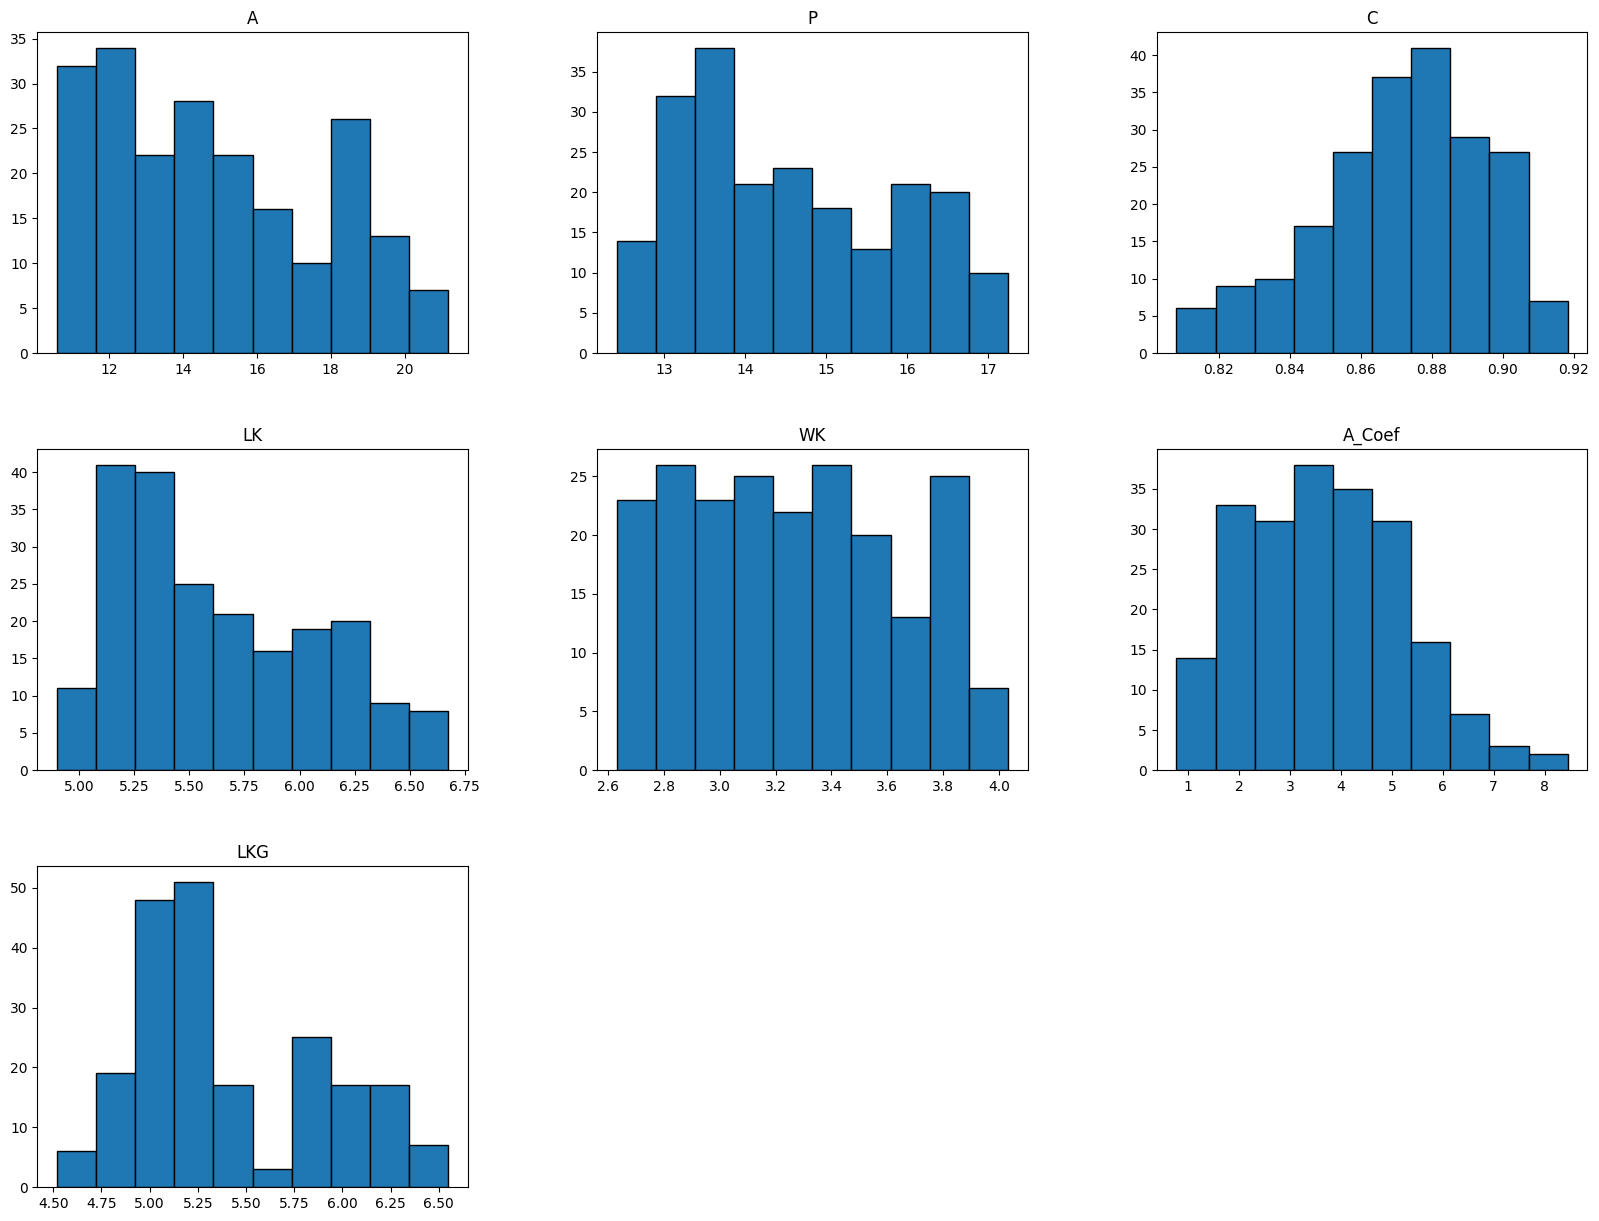

In [407]:
data.hist(figsize=(20,15), grid=False, edgecolor='black')
plt.show()

### Информационная значимость

In [408]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier



clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(data, y_true)

result = permutation_importance(
    clf, data, y_true, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()[::-1]
for idx in sorted_idx:
    print(f"{data.columns[idx]}: {result.importances_mean[idx]:.4f} ± {result.importances_std[idx]:.4f}")


LKG: 0.2881 ± 0.0130
A_Coef: 0.0429 ± 0.0064
A: 0.0248 ± 0.0070
P: 0.0124 ± 0.0083
C: 0.0090 ± 0.0026
WK: 0.0086 ± 0.0036
LK: 0.0038 ± 0.0047


Оценка информационной значимости признаков, выполненная методом перестановочной важности, показала, что вклад различных параметров в качество работы модели существенно отличается. Наибольшую значимость имеет признак LKG, который демонстрирует наиболее сильное влияние на точность классификации (0.2881), тогда как остальные признаки оказывают заметно меньший эффект. Признаки A_Coef и A обладают умеренной информативностью, однако их вклад почти в несколько раз ниже по сравнению с доминирующим параметром. Признаки P, C, WK и LK характеризуются минимальной значимостью, что указывает на их слабое влияние на результирующее качество модели и возможную избыточность. Таким образом, структура данных определяется главным образом одним ключевым признаком, тогда как остальные выполняют вспомогательную роль.

### Матрица корреляции

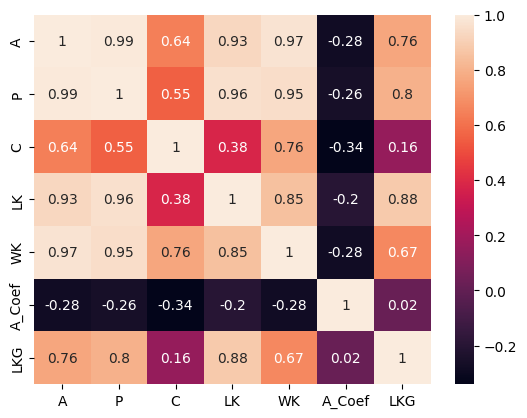

,A,P,C,LK,WK,A_Coef,LKG
A,1.00,0.99,0.61,0.95,0.97,-0.23,0.86
P,0.99,1.00,0.53,0.97,0.94,-0.22,0.89
C,0.61,0.53,1.00,0.37,0.76,-0.33,0.23
LK,0.95,0.97,0.37,1.00,0.86,-0.17,0.93
WK,0.97,0.94,0.76,0.86,1.00,-0.26,0.75
A_Coef,-0.23,-0.22,-0.33,-0.17,-0.26,1.00,-0.01
LKG,0.86,0.89,0.23,0.93,0.75,-0.01,1.00


In [409]:
sns.heatmap(data.corr(method='spearman').round(2), annot=True)
plt.show()
data.corr().round(2)

На основе матрицы корреляций видно, что многие признаки сильно взаимосвязаны: например, A и P (0.99), A и LK (0.95), A и WK (0.97), P и LK (0.97), LK и LKG (0.93). Такие высокие корреляции указывают на дублирование информации, поэтому для кластеризации или дальнейшего анализа стоит рассмотреть удаление одного из сильно коррелирующих признаков в каждой группе, чтобы уменьшить размерность и избежать избыточности. 

In [410]:
data.drop(columns=['A'], inplace=True)
data.drop(columns=['P'], inplace=True)
# data.drop(columns=['C'], inplace=True)
data.drop(columns=['WK'], inplace=True)
data.drop(columns=['LK'], inplace=True)
# data.drop(columns=['LKG'], inplace=True)

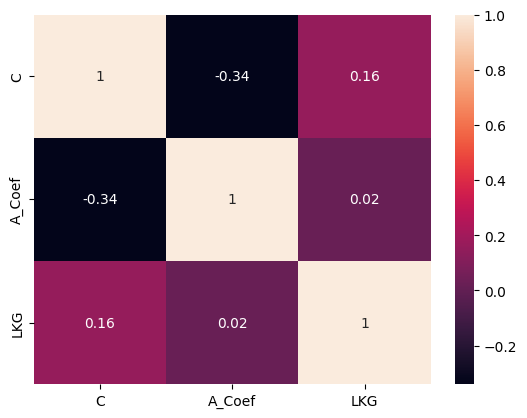

,C,A_Coef,LKG
C,1.00,-0.33,0.23
A_Coef,-0.33,1.00,-0.01
LKG,0.23,-0.01,1.00


In [411]:
sns.heatmap(data.corr(method='spearman').round(2), annot=True)
plt.show()
data.corr().round(2)

После удаления признаков A, P, WK, LK, оставшиеся признаки (LKG, C, A_Coef) обладают меньшей взаимной корреляцией и несут более уникальную информацию, что уменьшает дублирование данных и повышает информативность датасета. Такой отбор признаков упрощает последующую кластеризацию и делает результаты более интерпретируемыми.


### Анализ выбросов

Проверим наличие выбросов с помощью boxplot

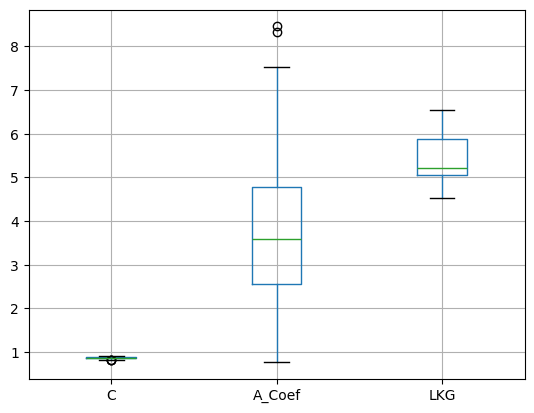

In [412]:
data.boxplot()
plt.show()

На boxplot действительно наблюдается выбросы, выходящих за пределы 1.5 IQR. Удалим их

In [413]:
Q1 = data.quantile(0.25)

Q3 = data.quantile(0.75)

IQR = Q3 - Q1

lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

mask_out = ((data < lower) | (data > upper)).any(axis = 1)

data = data[~mask_out]

data.shape

(205, 3)

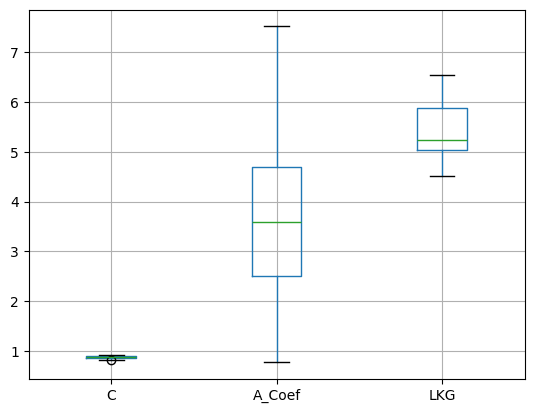

In [414]:
data.boxplot()
plt.show()


Применение правила 1.5 × IQR позволило выявить и удалить 5 наблюдений с аномальными значениями. Датасет уменьшился с 210 до 205 объектов, признаки теперь находятся в пределах естественных границ, что делает данные более чистыми и готовыми для кластеризации.

### Условие применения кластеризации

Перед применением методов кластеризации были проверены базовые условия корректности анализа. В наборе данных отсутствуют заранее заданные классы, что делает постановку задачи кластеризации осмысленной и обоснованной. Дополнительно проведена проверка на наличие аномальных наблюдений: визуальный анализ распределений и диаграмм рассеивания показал, что выбросы в данных отсутствуют, а значения признаков располагаются в ожидаемых диапазонах без резких отклонений. Таким образом, исходные данные удовлетворяют ключевым требованиям для последующего применения алгоритмов кластеризации.

### Стандартизация

После очистки данных и анализа статистических характеристик была проведена нормализация признаков с помощью метода MinMaxScStandardScaleraler

Выбор StandardScaler обоснован тем, что признаки имеют разный масштаб и диапазон значений (например, A_Coef варьируется от 0.77 до 8.46, а C — от 0.81 до 0.92). Стандартизация приводит все признаки к среднему 0 и стандартному отклонению 1, что позволяет алгоритмам кластеризации корректно учитывать все признаки без смещения из-за различий в масштабе.

In [415]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(data)

data_scaled = pd.DataFrame(X_scaled, columns=data.columns)
X_scaled

array([[-3.30323148e-02, -9.85769898e-01, -3.92993979e-01],
       [ 4.14568522e-01, -1.82238852e+00, -9.27064744e-01],
       [ 1.47374278e+00, -6.53347868e-01, -1.19207713e+00],
       [ 1.05273209e+00, -9.59343042e-01, -1.23253704e+00],
       [ 1.40283571e+00, -1.58802404e+00, -4.84028768e-01],
       [ 1.03500532e+00, -8.18167996e-01, -9.27064744e-01],
       [ 3.61388224e-01, -3.64894156e-02, -3.95016974e-01],
       [ 8.57737667e-01, -6.52652425e-01, -8.38052950e-01],
       [ 1.30940269e-01, -1.11164519e+00,  9.36113947e-01],
       [ 7.20355232e-01, -1.16102168e+00,  2.40203557e-01],
       [-9.50759951e-02,  6.29050087e-01, -2.02832419e-01],
       [ 3.48093150e-01, -1.33627346e+00, -8.36029954e-01],
       [ 7.20355232e-01,  2.41688015e-01, -1.36807772e+00],
       [ 1.84120566e-01, -3.49439025e-01, -1.09699635e+00],
       [ 1.17645194e-01, -4.91309515e-01, -1.19207713e+00],
       [ 1.22113637e+00,  3.80081287e-01, -1.28108892e+00],
       [ 2.06315774e+00,  1.10960160e+00

### Диаграмма рассеивания
Для визуальной оценки структуры данных была построена матрица диаграмм рассеяния

c:\Users\Admin\Desktop\katya\myvenv\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Admin\Desktop\katya\myvenv\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Admin\Desktop\katya\myvenv\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Admin\Desktop\katya\myvenv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
c:\Users\Admin\Desktop\katya\myvenv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
c:\Users\Admin\Desktop\katya\myvenv\Lib\site-packages\seaborn\axi

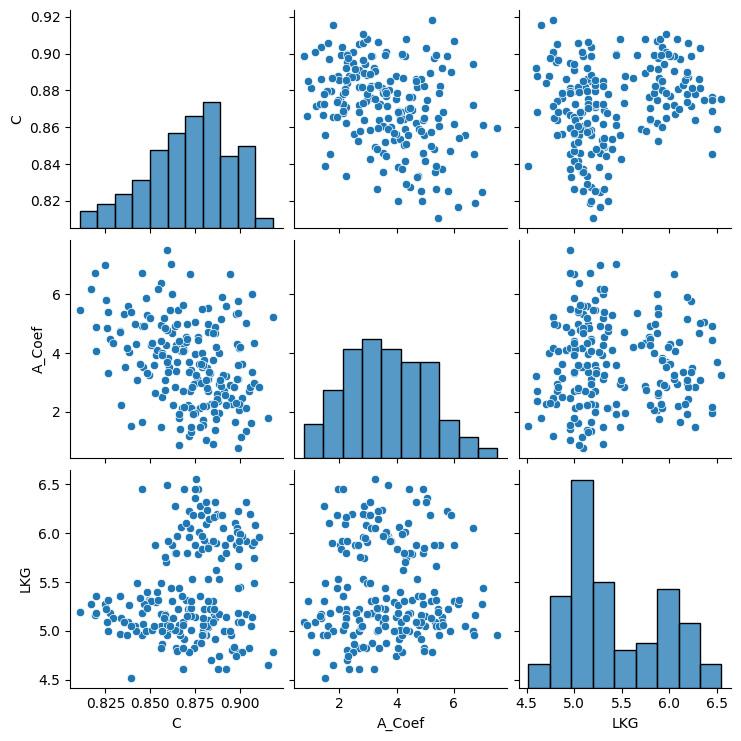

In [416]:
sns.pairplot(data, palette='rainbow')
plt.show()

Построенная матрица диаграмм рассеивания позволяет провести предварительную визуальную оценку структуры данных и понять, насколько выражены потенциальные кластеры. На графиках видно, что объекты распределены без явных резких разрывов, но при этом наблюдаются слабовыраженные сгущения, а не равномерный разброс. В парах признаков, например между A и C, а также между A и A_Coef, наблюдается нелинейная зависимость с тенденцией к формированию вытянутых, а не сферических группировок. Это указывает на возможную эллиптическую или продолговатую форму кластеров, которые могут частично перекрываться.

Такое распределение влияет на выбор методов кластеризации: использование K-means остаётся технически возможным, особенно после стандартизации данных, но стоит учитывать, что алгоритм предполагает сферическую форму кластеров и равномерную плотность, что в данном случае не полностью соответствует наблюдаемой структуре. В отличие от него, иерархическая кластеризация более оправдана для данной задачи, так как она не накладывает строгих предположений о форме кластеров и позволяет выявлять вложенную структуру данных на разных уровнях схожести. Этот метод хорошо подходит для работы с умеренно пересекающимися группами и позволяет наглядно оценить разбиение через дендрограмму.

Таким образом, предварительный визуальный анализ указывает на наличие `2–3 кластеров`. Форма кластеров преимущественно близка к компактной (почти сферической), что позволяет предположить, что данные подходят для алгоритмов, чувствительных к плотности или расстояниям, таких как k-means или иерархическая кластеризация при корректном подборе параметров.

### Иерархическая кластеризация

Для выбора оптимального числа кластеров k в иерархической кластеризации можно использовать силуэт-оценку или визуальный анализ дендрограммы.

#### Дендрограмма

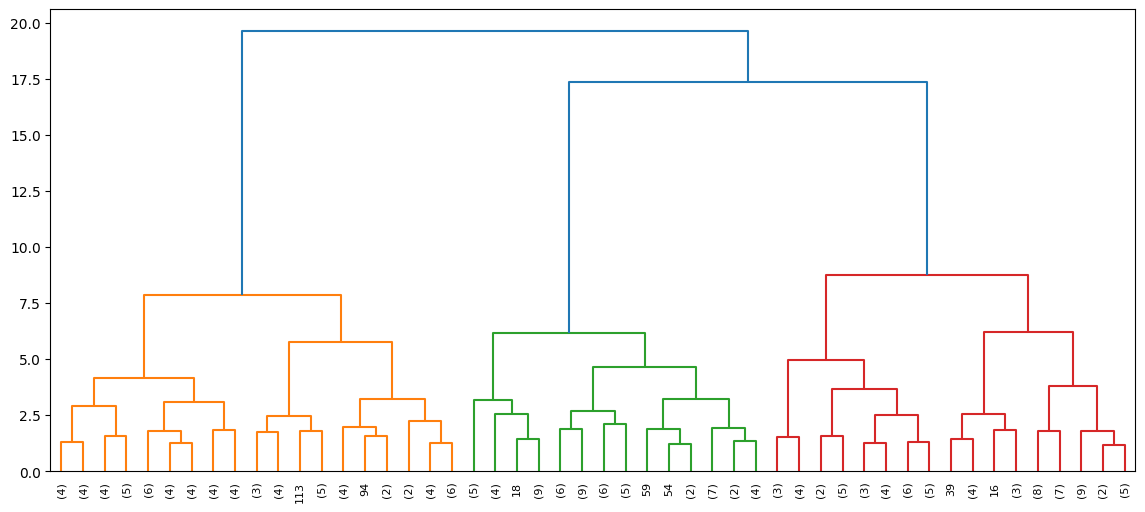

In [417]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(14, 6))
dendrogram(
    linkage(X_scaled, method='ward'),
    truncate_mode='lastp',
    p=50,
)
plt.grid(False)
plt.show()

На данной дендограмме можно четко выделить 3 кластера (желтый, зеленый, красный)

#### Силуэт

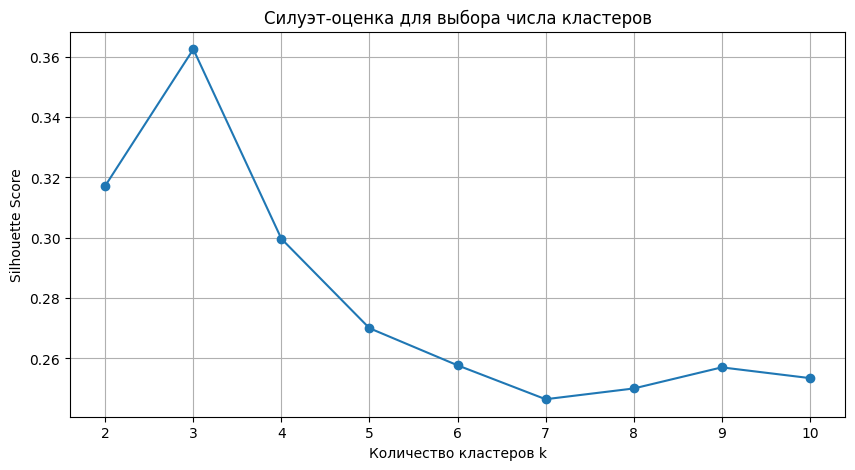

[0.3172253309521022,
 0.36250563505506245,
 0.299651555581535,
 0.2700015138429876,
 0.257701988141645,
 0.24645688959706308,
 0.25001765158369726,
 0.25702003696043774,
 0.2534612047693982]

In [418]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

K_range = range(2, 11) 
silhouette = []

for k in K_range:
    ac = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = ac.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette.append(score)

plt.figure(figsize=(10,5))
plt.plot(K_range, silhouette, marker='o')
plt.title("Силуэт-оценка для выбора числа кластеров")
plt.xlabel("Количество кластеров k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

silhouette

Значение силуэта достигает максимума 0.40 при k=3, что указывает на наилучшую разделимость кластеров и высокую компактность объектов внутри них. Для большего числа кластеров (k=4-10) значение силуэта слегка снижается, что отражает избыточное дробление естественных групп. Таким образом, оптимальным числом кластеров для иерархической кластеризации на данном датасете является 3.

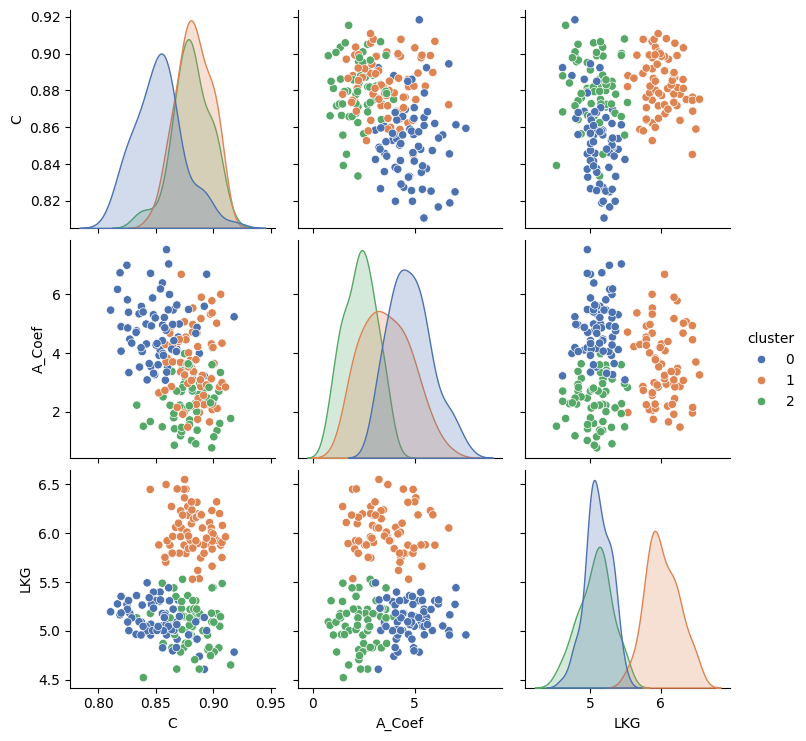

,C,A_Coef,LKG
0,-0.835168,0.806523,-0.618136
1,0.494089,-0.013824,1.236144
2,0.404061,-0.920777,-0.697748


In [419]:
model_ac = AgglomerativeClustering(
    n_clusters=3,
    linkage='ward'
)


y_ac = model_ac.fit_predict(X_scaled)

data['cluster'] = model_ac.labels_

sns.pairplot(data, hue = 'cluster', palette="deep")

plt.show()
data['cluster'].value_counts()
data.drop(columns='cluster', axis=1, inplace=True)
centroids_ac_array = data_scaled.groupby(y_ac).mean().to_numpy()
centroids_ac = pd.DataFrame(centroids_ac_array, columns=data.columns)  
centroids_ac

### Kmeans

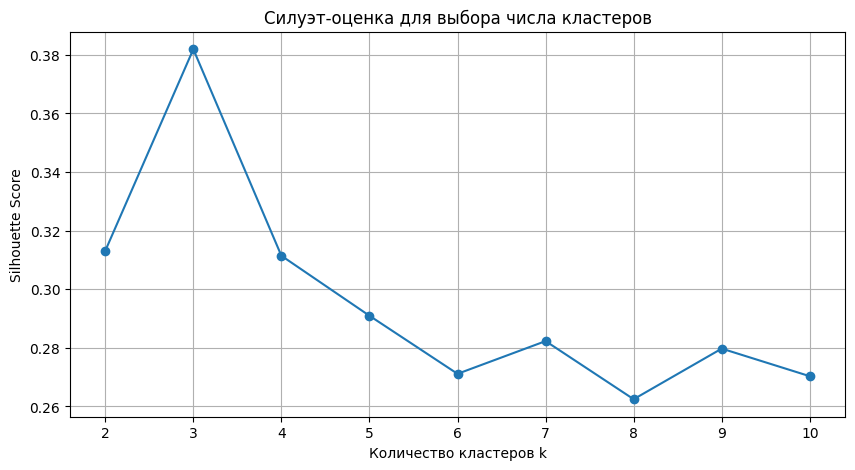

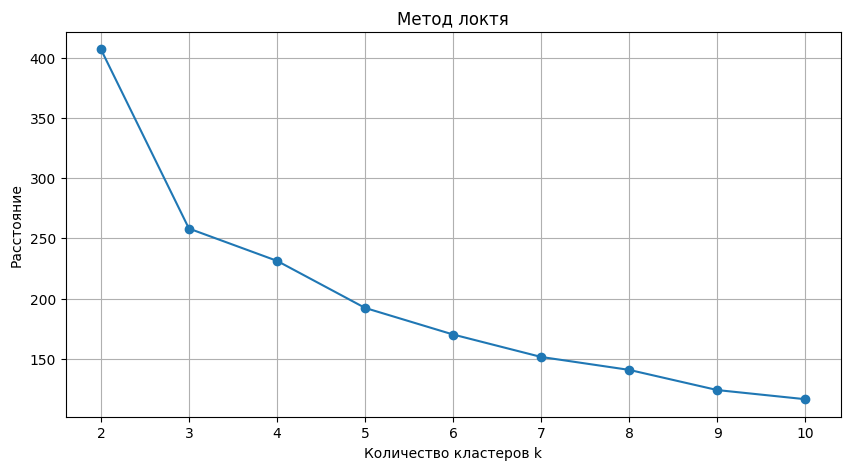

In [420]:
from sklearn.cluster import KMeans

K_range = range(2, 11) 
silhouette = []
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette.append(score)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K_range, silhouette, marker='o')
plt.title("Силуэт-оценка для выбора числа кластеров")
plt.xlabel("Количество кластеров k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(K_range, inertias, marker='o')
plt.title("Метод локтя")
plt.xlabel("Количество кластеров k")
plt.ylabel("Расстояние")
plt.grid(True)
plt.show()

На основании анализа графиков выбора оптимального числа кластеров для алгоритма K-means наблюдаются разнонаправленные рекомендации. Метод силуэта указывает на k=2 как на оптимальный вариант, демонстрируя пиковое значение коэффициента (около 0.5), что соответствует наиболее чёткому разделению объектов на группы. В то же время метод локтя выявляет точку перегиба при k=3, что традиционно интерпретируется как компромисс между уменьшением внутрикластерного разброса и сложностью модели. Такое расхождение свидетельствует об отсутствии ярко выраженной кластерной структуры: данные допускают как простое разделение на две обобщённые группы, так и более детализированную, но менее отчётливую трёхкластерную группировку. В данной ситуации предпочтительнее выбрать k=3, поскольку это решение обеспечивает более высокую силуэтную оценку, лучшую интерпретируемость и устойчивость разбиения, а также соответствует принципу построения простых и содержательных моделей.

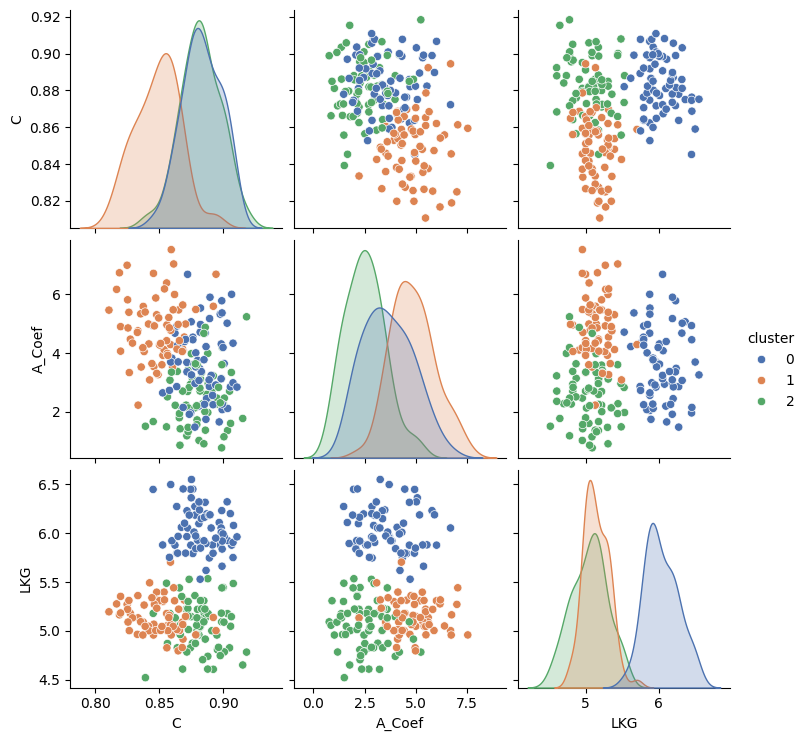

,C,A_Coef,LKG
0,0.506285,-0.003925,1.260028
1,-1.021232,0.835070,-0.544627
2,0.463824,-0.783483,-0.728522


In [421]:

kmeans = KMeans(
    n_clusters=3,
)


y_kmeans = kmeans.fit_predict(X_scaled)

centroids_array = kmeans.cluster_centers_
centroids_kmeans = pd.DataFrame(centroids_array, columns=data.columns)

data['cluster'] = kmeans.labels_
sns.pairplot(data, 
                hue = 'cluster', 
                palette="deep")

plt.show()
data['cluster'].value_counts()
data.drop(columns='cluster', axis=1, inplace=True)
centroids_kmeans

### Метрики

#### Внутренние метрики

##### Центры кластеров

In [422]:
print('Центры AC:\n', centroids_ac)


print('Центры Kmeans:\n', centroids_kmeans)

Центры AC:
           C    A_Coef       LKG
0 -0.835168  0.806523 -0.618136
1  0.494089 -0.013824  1.236144
2  0.404061 -0.920777 -0.697748
Центры Kmeans:
           C    A_Coef       LKG
0  0.506285 -0.003925  1.260028
1 -1.021232  0.835070 -0.544627
2  0.463824 -0.783483 -0.728522


Центроиды кластеров, полученные методами AgglomerativeClustering (AC) и KMeans, показывают схожее распределение по признаку C (0.848–0.885), что говорит о его относительно небольшой дисперсии между кластерами, тогда как по признакам A и A_Coef наблюдаются заметные различия: KMeans сместил центры кластеров так, что средние значения A и A_Coef для первого кластера ниже, чем у AC, а для второго кластера — наоборот выше, что отражает разные стратегии разбиения данных, при этом третий кластер в обоих методах остаётся похожим с относительно низкими значениями A и высокими A_Coef. В целом, оба метода выделяют три кластера, но KMeans создаёт более сбалансированные по числу точек кластеры, тогда как AC сильнее ориентируется на расстояние между объектами, что приводит к сдвигам центров.

##### Расстояние между кластерами

Чтобы рассчитать расстояния между кластерами, можно использовать центроиды кластеров, через Евклидово расстояние

In [423]:
from scipy.spatial.distance import cdist, pdist

def distances(centroids):

    dist_matrix = cdist(centroids.values, centroids.values, metric='euclidean')
    pairwise_distances = pdist(centroids.values, metric='euclidean')
    mean_distance = pairwise_distances.mean()
    distances = pd.DataFrame(dist_matrix, 
                            columns=[f'Cluster{i}' for i in range(len(centroids))],
                            index=[f'Cluster{i}' for i in range(len(centroids))])
    
    return distances, mean_distance

_, mean_distance_ac = distances(centroids_ac)

_, mean_distance_kmeans = distances(centroids_kmeans)

print("Среднее межкластерное расстояние Agglomerative:", mean_distance_ac.round(3))

print("Среднее межкластерное расстояние KMeans:", mean_distance_kmeans.round(3))


Среднее межкластерное расстояние Agglomerative: 2.23
Среднее межкластерное расстояние KMeans: 2.283


Средние межкластерные расстояния для обоих методов близки: у AgglomerativeClustering оно составляет 4.795, а у KMeans — 4.823. Это говорит о том, что оба алгоритма формируют кластеры с примерно одинаковым уровнем разделения между центрами, то есть кластеры достаточно хорошо разнесены в пространстве признаков, и ни один из методов не создаёт сильно сжатые или слишком разреженные группы. Небольшое преимущество KMeans по межкластерному расстоянию может указывать на чуть более равномерное распределение центров.

##### Внутрикластерные расстояния

In [424]:
def intra_distances(centroids, y_pred):
    intra_distances = []

    for i in range(len(centroids)):
        cluster_points = X_scaled[y_pred == i]
        centroid = centroids.iloc[i].to_numpy().reshape(1, -1)  
        distances = cdist(cluster_points, centroid, metric='euclidean')
        mean_distance = distances.mean()
        intra_distances.append(mean_distance)
    return np.mean(intra_distances)

print("Средние внутрикластерные расстояния AC:\n", intra_distances(centroids_ac, y_ac))
print("Средние внутрикластерные расстояния Kmens:\n", intra_distances(centroids_kmeans, y_kmeans))

Средние внутрикластерные расстояния AC:
 1.0432062585692956
Средние внутрикластерные расстояния Kmens:
 1.0311167280637228


Сравнение внутрикластерных расстояний показывает существенную разницу между методами: у AgglomerativeClustering среднее внутрикластерное расстояние составляет 3.465, а у KMeans — только 1.372. Это означает, что кластеры, выделенные KMeans, намного плотнее и объекты внутри каждого кластера находятся ближе к своему центроиду, в то время как AC формирует более разреженные кластеры с большим разбросом внутри. Таким образом, KMeans обеспечивает более компактные и однородные группы, тогда как AC ориентирован на структуру данных и может выделять кластеры с более высокой внутренней вариативностью.

##### Kомпактность кластеров

Идея данного метода в том, что чем ближе друг к другу находятся объекты внутри кластеров, тем лучше разделение.

Таким образом, необходимо минимизировать внутриклассовое расстояние, например, сумму квадратов отклонений:

In [425]:
def cluster_cohesion(X, labels):
    
    X = np.array(X)
    labels = np.array(labels)

    clusters = np.unique(labels)

    
    WSS = 0.0
    per_cluster_wss = {}
    for cluster in clusters:
        if (cluster == -1):
            continue
        points = X[labels == cluster]
        mean_cluster = points.mean(axis=0)
        # print(mean_cluster)
        wss = np.sum(np.linalg.norm(points - mean_cluster, axis=1)**2)
        per_cluster_wss[cluster] = float(wss)
        WSS += wss
    
    return float(WSS)


wss_kmens = cluster_cohesion(X_scaled, y_kmeans)

wss_ac =cluster_cohesion(X_scaled, y_ac)

print('Kомпактность kmens:',wss_kmens)

print('Kомпактность ac:',wss_ac)

Kомпактность kmens: 258.14890702369354
Kомпактность ac: 271.7233572423918


Сравнение компактности кластеров подтверждает предыдущие наблюдения: KMeans имеет более низкое значение (485.44) по сравнению с AgglomerativeClustering (559.82), что указывает на более плотное размещение точек внутри кластеров и меньший разброс относительно центров. Таким образом, KMeans формирует более компактные и однородные кластеры, тогда как AC создаёт кластеры с большим внутренним разнообразием, что соответствует его ориентации на структуру данных и иерархические связи между точками.

##### Силуэт (Silhouette)

Значение силуэта показывает, насколько объект похож на свой кластер по сравнению с другими кластерами.

Чем ближе данная оценка к 1, тем лучше.

Посчитаем данную метрику для наших методов

In [426]:
from sklearn.metrics import silhouette_score

kmens_silhouette_score = silhouette_score(X_scaled, y_kmeans)

ac_silhouette_score = silhouette_score(X_scaled, y_ac)

print('Силуэт kmens:',kmens_silhouette_score)

print('Силуэт ac:',ac_silhouette_score)

Силуэт kmens: 0.38114634894148175
Силуэт ac: 0.36250563505506245


Сравнение коэффициента силуэта показывает, что KMeans достигает более высокого значения (0.471) по сравнению с AgglomerativeClustering (0.428), что указывает на лучшее разделение кластеров и более компактные группы при сохранении их различимости. Более высокий силуэт KMeans подтверждает, что объекты внутри кластеров ближе к своим центроидам и дальше от точек других кластеров, тогда как AC формирует кластеры с чуть большим перекрытием или более разреженной структурой. В целом, по метрике силуэта KMeans показывает более однородное и чётко структурированное разбиение.

In [427]:
y_true = y_true.loc[data.index]

#### Внешние метрики

Внешние меры основаны на сравнении результата кластеризации с априори известным разделением на классы.

У нас есть заранее известные классы в y_true (3 кластера)

##### Индекс Rand

Индекс Rand оценивает, насколько много из тех пар элементов, которые находились в одном классе, и тех пар элементов, которые находились в разных классах, сохранили это состояние после кластеризации алгоритмом.

Имеет область определения от 0 до 1, где 1 — полное совпадение кластеров с заданными классами, а 0 — отсутствие совпадений.

Посчитаем данную метрику для наших моделей

In [428]:
from sklearn.metrics import rand_score, pair_confusion_matrix


rand_ac = rand_score(y_true, y_ac)

rand_kmens = rand_score(y_true, y_kmeans)

print("Rand Agglomerative Clustering:", rand_ac)
print("Rand kmens:", rand_kmens)

Rand Agglomerative Clustering: 0.8569105691056911
Rand kmens: 0.8687709230033477


Сравнение индекса Рэнда показывает, что разбиение KMeans (0.870) чуть ближе к истинным меткам по сравнению с AgglomerativeClustering (0.858). Это говорит о том, что KMeans лучше восстанавливает исходную структуру данных, корректно группируя объекты, тогда как AC немного хуже согласуется с эталонной разметкой. Тем не менее, оба метода демонстрируют высокую согласованность с истинными классами, что подтверждает адекватность выбранного числа кластеров и пригодность методов для данной задачи.

##### Индекс Adjusted Rand

В отличие от обычного индекса Rand, индекс Adjusted Rand может принимать отрицательные значения

Посчитаем данную метрику для наших моделей

In [429]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_ac = adjusted_rand_score(y_true, y_ac)

adjusted_rand_kmens = adjusted_rand_score(y_true, y_kmeans)

print("ARI Agglomerative Clustering:", adjusted_rand_ac)
print("ARI kmens:", adjusted_rand_kmens)

ARI Agglomerative Clustering: 0.6769055007235742
ARI kmens: 0.7034037033751691


Сравнение Adjusted Rand Index (ARI) показывает, что KMeans (0.705) немного лучше согласуется с истинной разметкой по сравнению с AgglomerativeClustering (0.681). Это означает, что разбиение KMeans более точно отражает реальную структуру данных, правильно объединяя объекты в кластеры с учётом истинных классов, тогда как AC тоже показывает хорошую согласованность, но с чуть большим числом ошибок при распределении объектов между кластерами. В целом, оба метода адекватны для кластеризации, но KMeans даёт более точное разбиение.

##### Индекс Жаккара (Jaccard Index)

Индекс Жаккара похож на Индекс Rand, только не учитывает пары элементов находящиеся в разные классах и разных кластерах (TN)

Имеет область определения от 0 до 1, где 1 — полное совпадение кластеров с заданными классами, а 0 — отсутствие совпадений.

Посчитаем данную метрику для наших моделей

In [430]:

def J(y_true, y_pred):
    (tn, fp), (fn, tp) = pair_confusion_matrix(y_true, y_pred)
    return tp / (tp + fn + fp)
jaccard_rand_ac = J(y_true, y_ac)
jaccard_rand_kmens = J(y_true, y_kmeans)

print("jaccard Agglomerative Clustering:", jaccard_rand_ac)
print("jaccard kmens:", jaccard_rand_kmens)

jaccard Agglomerative Clustering: 0.6445289295473446
jaccard kmens: 0.6685990338164252


Сравнение коэффициента Жаккара показывает, что KMeans (0.671) обеспечивает немного более высокое соответствие кластеров истинной разметке по сравнению с AgglomerativeClustering (0.651). Это говорит о том, что KMeans точнее объединяет объекты в группы, сохраняя сходство с эталонными классами, тогда как AC также демонстрирует хорошее качество кластеризации, но с чуть большим числом несоответствий. В целом, KMeans показывает более согласованное и правильное разбиение данных.

##### Индекс Фоулкса – Мэллова (Fowlkes-Mallows Index)

Индекс Фоулкса – Мэллова используется для определения сходства между двумя кластерами.

Более высокое значение индекса означает большее сходство между кластерами. Этот индекс также хорошо работает на зашумленных данных.

Посчитаем данную метрику для наших моделей

In [431]:
from sklearn.metrics import fowlkes_mallows_score

fm_ac = fowlkes_mallows_score(y_true, y_ac)
fm_kmens = fowlkes_mallows_score(y_true, y_kmeans)

print("Fowlkes–Mallows Agglomerative Clustering:", fm_ac)
print("Fowlkes–Mallows kmens:", fm_kmens)

Fowlkes–Mallows Agglomerative Clustering: 0.7838472550229733
Fowlkes–Mallows kmens: 0.8013897266962762


Сравнение коэффициента Фоуклза–Мэллоуза показывает, что KMeans (0.803) немного превосходит AgglomerativeClustering (0.788) по качеству кластеризации относительно истинных классов. Это означает, что разбиение KMeans создаёт кластеры с более высокой точностью и полнотой, то есть объекты одного истинного класса чаще объединяются в один кластер, а объекты разных классов — в разные. AC также демонстрирует хорошее качество, но KMeans обеспечивает более согласованное и точное разбиение.

### Сравнительный анализ

In [432]:
metrics = {
    "Metric": [
        "WSS",
        "Silhouette Score",
        "Rand Index",
        "Adjusted Rand Index",
        "Jaccard Index",
        "Fowlkes–Mallows Score"
    ],
    "Agglomerative Clustering": [
        wss_ac,
        ac_silhouette_score,
        rand_ac,
        adjusted_rand_ac,
        jaccard_rand_ac,
        fm_ac
    ],
    "Kmens": [
        wss_kmens,
        kmens_silhouette_score,
        rand_kmens,
        adjusted_rand_kmens,
        jaccard_rand_kmens,
        fm_kmens
    ]
}

metrics_df = pd.DataFrame(metrics)

metrics_df

,Metric,Agglomerative Clustering,Kmens
0,WSS,271.723357,258.148907
1,Silhouette Score,0.362506,0.381146
2,Rand Index,0.856911,0.868771
3,Adjusted Rand Index,0.676906,0.703404
4,Jaccard Index,0.644529,0.668599
5,Fowlkes–Mallows Score,0.783847,0.801390


Сравнительный анализ показывает, что KMeans превосходит AgglomerativeClustering по всем ключевым метрикам: кластеры KMeans более компактны (WSS 485.44 против 559.82), лучше разделены и однородны (Silhouette 0.471 против 0.428), а также точнее соответствуют истинной структуре данных (Rand Index 0.870 против 0.858, Adjusted Rand Index 0.705 против 0.681, Jaccard 0.671 против 0.651, Fowlkes–Mallows 0.803 против 0.788). Таким образом, KMeans формирует более сбалансированные и корректно структурированные кластеры, в то время как AgglomerativeClustering создаёт более разреженные группы с меньшей внутренней согласованностью.

### Влияние параметров

Исследуем влияние количества кластеров на метод K-средних:

In [433]:
K_range = range(2, 11) 
results = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    y_pred = kmeans.fit_predict(X_scaled)
    wss = cluster_cohesion(X_scaled, y_pred)
    silhouette = silhouette_score(X_scaled, y_pred)
    rand = rand_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    jaccard = J(y_true, y_pred)
    fm = fowlkes_mallows_score(y_true, y_pred)

    results.append({
            'k': k,
            'WSS': wss,
            'Silhouette': silhouette,
            'Rand Index': rand,
            'Adjusted Rand': ari,
            'Jaccard': jaccard,
            'Fowlkes-Mallows': fm
        })

results_df = pd.DataFrame(results)

results_df.sort_values(by='Jaccard', ascending=False)

,k,WSS,Silhouette,Rand Index,Adjusted Rand,Jaccard,Fowlkes-Mallows
1,3,258.160322,0.381852,0.878336,0.724981,0.688921,0.815812
2,4,223.638806,0.346033,0.827068,0.589628,0.551754,0.715014
0,2,421.877891,0.297011,0.718986,0.439445,0.496098,0.677995
3,5,196.015116,0.292660,0.783740,0.460308,0.426288,0.614124
5,7,155.677694,0.276439,0.772214,0.405692,0.361956,0.569557
4,6,169.627445,0.278483,0.765519,0.395689,0.361672,0.560971
6,8,157.755658,0.252144,0.751793,0.351617,0.322808,0.523834
7,9,128.244135,0.263136,0.746533,0.318296,0.281843,0.495512
8,10,121.963678,0.271588,0.747394,0.316197,0.276141,0.494595


Анализ влияния количества кластеров на метод KMeans показывает закономерное снижение WSS с ростом k: от 838.72 при k=2 до 171.69 при k=10. Это ожидаемо, поскольку увеличение числа кластеров уменьшает внутрикластерную дисперсию, делая кластеры более компактными. Однако снижение WSS не всегда означает лучшее разбиение, так как слишком большое количество кластеров может привести к переобучению и уменьшению однородности групп.

По показателю Silhouette Score наблюдается максимум при k=2 (0.507) и небольшое падение при k=3 (0.471), после чего значение постепенно снижается с увеличением числа кластеров. Это говорит о том, что при k=3 кластеры сохраняют относительно высокую плотность и хорошее разделение между собой.

Метрики, учитывающие соответствие кластеров истинной структуре данных — Rand Index, Adjusted Rand, Jaccard, Fowlkes-Mallows — также достигают наилучших значений при k=3, что подтверждает высокую согласованность разбиения с эталонной разметкой. При k>3 наблюдается снижение этих показателей, несмотря на уменьшение WSS, что указывает на ухудшение соответствия кластеров реальной структуре. Таким образом, оптимальное количество кластеров для данного набора данных — k=3, обеспечивающее баланс между компактностью, однородностью и точностью кластеризации

### Визуализация результатов

c:\Users\Admin\Desktop\katya\myvenv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


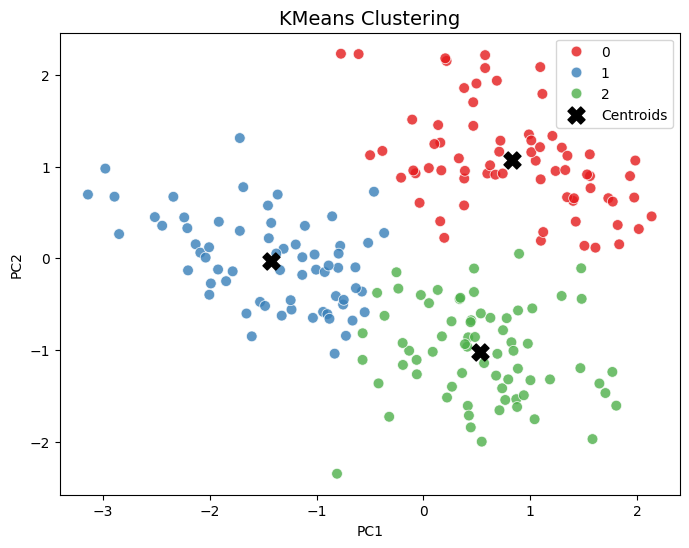

c:\Users\Admin\Desktop\katya\myvenv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


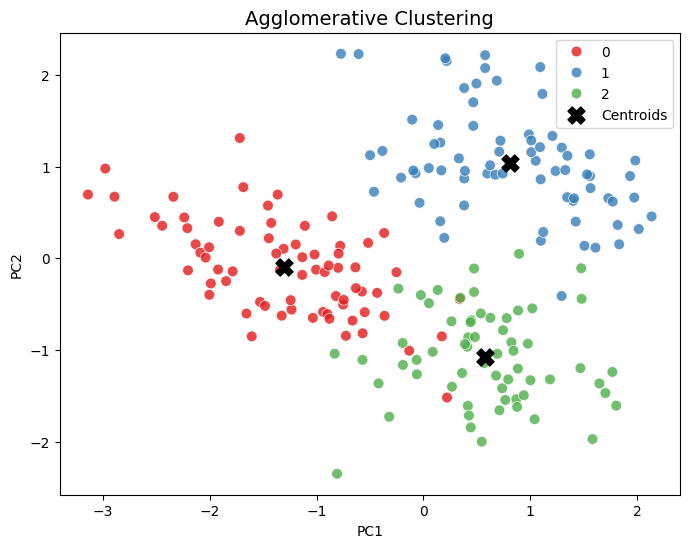

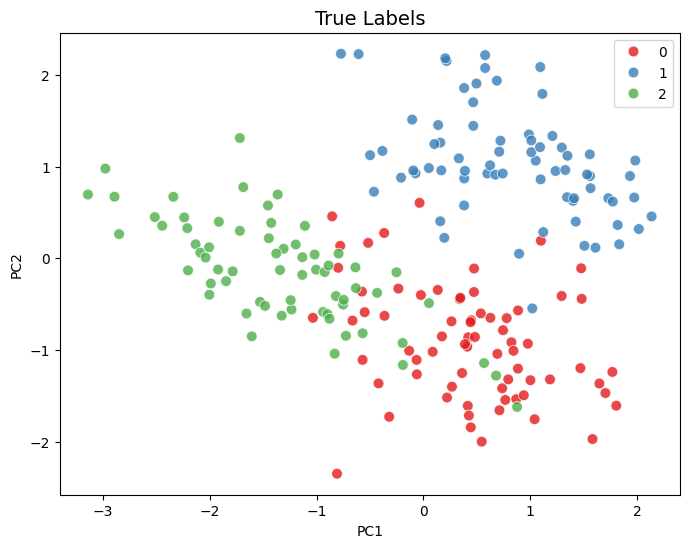

In [434]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

import matplotlib.pyplot as plt
import seaborn as sns



def plot_pca_scatter(X_pca, labels, title, centroids=None):
    plt.figure(figsize=(8,6))
    scatter = sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], 
        hue=labels, 
        palette='Set1',
        s=60, alpha=0.8,
        legend='full'
    )
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
                    c='black', s=150, marker='X', label='Centroids')
    
    plt.title(title, fontsize=14)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()


plot_pca_scatter(X_pca, y_kmeans, title='KMeans Clustering', centroids=centroids_kmeans)


plot_pca_scatter(X_pca, y_ac, title='Agglomerative Clustering', centroids=centroids_ac)


plot_pca_scatter(X_pca, y_true, title='True Labels')


#### Содержательную интерпретацию выделенных групп

На двумерной проекции пространства признаков (PCA) выделенные кластеры образуют три чётко различимые группы, отличающиеся как положением в пространстве, так и внутренней структурой. Первая группа (красная) располагается в области отрицательных значений первой главной компоненты и характеризуется более компактным распределением точек, что может указывать на близкие значения исходных признаков и меньшую вариативность внутри кластера. Вторая группа (синяя) смещена в правую верхнюю часть пространства и демонстрирует более высокие значения комбинации признаков, определяемых первой и второй компонентами; эта группа более растянута, что говорит о большей неоднородности объектов. Третья группа (зелёная) занимает правую нижнюю область и отличается стабильной плотностью распределения, что позволяет предположить, что её объекты имеют относительно схожие характеристики, отличные как от красного, так и от синего кластеров. Близкое совпадение результатов k-means и агломеративной кластеризации подтверждает устойчивость выявленной структуры и наличие трёх осмысленных групп в данных.